# Práctica Minería de Datos

**Este documento contiene la parte práctica de la tarea de evaluación del módulo de Minería de Datos.** 

**La idea es que vayas avanzando en el documento y completando códigos (asegurando ejecutar para que se vean las salidas) y preguntas asociadas.**

**Una vez terminado, lo guardas con el nombre "PracticaMineria_NombreApellido.ipynb" para adjuntarlo a la entrega.** 

**A disfrutar del proceso!**

## Pregunta 1
Indica en el siguiente chunk el código necesario para importar el conjunto de datos **"FEV_data.csv"** y muestra la información del archivo. 

Información sobre el archivo aquí: 
https://view.officeapps.live.com/op/view.aspx?src=http%3A%2F%2Fwww.emersonstatistics.com%2Fdatasets%2Ffev.doc&wdOrigin=BROWSELINK

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import importlib
import NuestrasFunciones as clase  # Módulo de funciones de la clase
import my_funcs as my              # Módulo con funciones propias :)

pd.set_option('display.max_columns', None)

In [4]:
# Lectura del archivo
df = pd.read_csv(r"C:\Users\milow\Desktop\Máster_UCM\1.Módulos\6.Minería_Datos\4.Tarea\Práctica Python\Datos\FEV_data.csv")

# Información
df

,seqnbr,subjid,age,fev,height,sex,smoke
0,1,301,9,1.708,57.0,2,2
1,2,451,8,1.724,67.5,2,2
2,3,501,7,1.720,54.5,2,2
3,4,642,9,1.558,53.0,1,2
4,5,901,9,1.895,57.0,1,2
...,...,...,...,...,...,...,...
649,650,73041,16,4.270,67.0,1,1
650,651,73042,15,3.727,68.0,1,1
651,652,73751,18,2.853,60.0,2,2
652,653,75852,16,2.795,63.0,2,1


In [5]:
df.duplicated().sum() # No hay duplicados.

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seqnbr  654 non-null    int64  
 1   subjid  654 non-null    int64  
 2   age     654 non-null    int64  
 3   fev     654 non-null    float64
 4   height  654 non-null    float64
 5   sex     654 non-null    int64  
 6   smoke   654 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 35.9 KB


¿Cuantos registros y variables tiene el archivo? ¿Tienen las variables el tipo correcto en relación a su lógica naturaleza?

**Respuesta**: <br>
- El archivo `FEV_data.csv` contiene en total **7 variables** (columnas) y **654 registros** (filas).
- Todas las variables (`seqnbr`, `subjid`, `age`, `fev`, `height`) tienen tipos de datos correctos a excepción de `sex` y `smoke`, las cuales se tratan más bien de variables categóricas binarias.
- Vamos a seguir la convención y **cambiar los valores de dichas variables binarias a 0s y 1s** en vez de 1s y 2s.

In [7]:
cat_cols = ['sex', 'smoke']

# cambiar valores '2' a '0' y columnas a categóricas:
for col in cat_cols:
    df[col] = df[col].replace(2,0).astype('category')

In [8]:
for col in cat_cols:
    print(df[col].value_counts(sort=False), '\n')

sex
0    318
1    336
Name: count, dtype: int64 

smoke
0    589
1     65
Name: count, dtype: int64 



## Pregunta 2

Sabiendo que la variable objetivo es *Fev*. Presenta un gráfico con las relaciones de asociación de los predictores frente a Fev. 

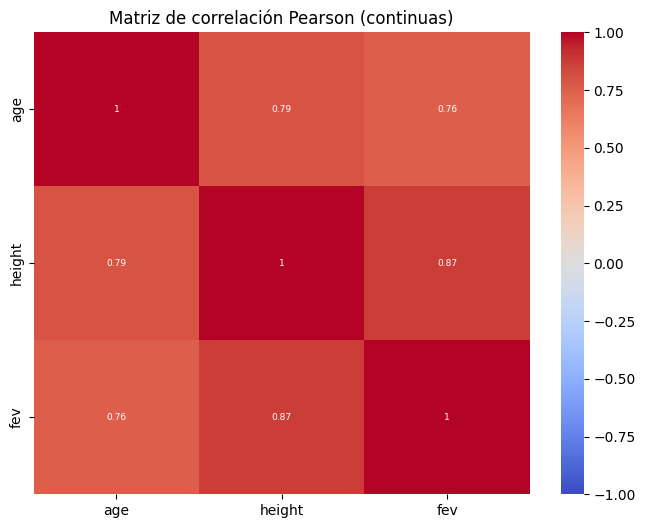

In [9]:
# Gráfico de relaciones con la objetivo
plt.figure(figsize=(8,6))

# Excluimos 'subjid' y 'seqnbr' (columnas de identificación) y las categóricas.
sns.heatmap(df[['age', 'height', 'fev']].corr(),
            annot=True, annot_kws={'fontsize': 6.5},
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación Pearson (continuas)')

plt.show()

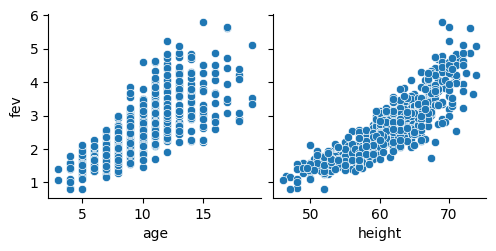

In [10]:
sns.pairplot(df, x_vars=['age', 'height'], y_vars='fev');

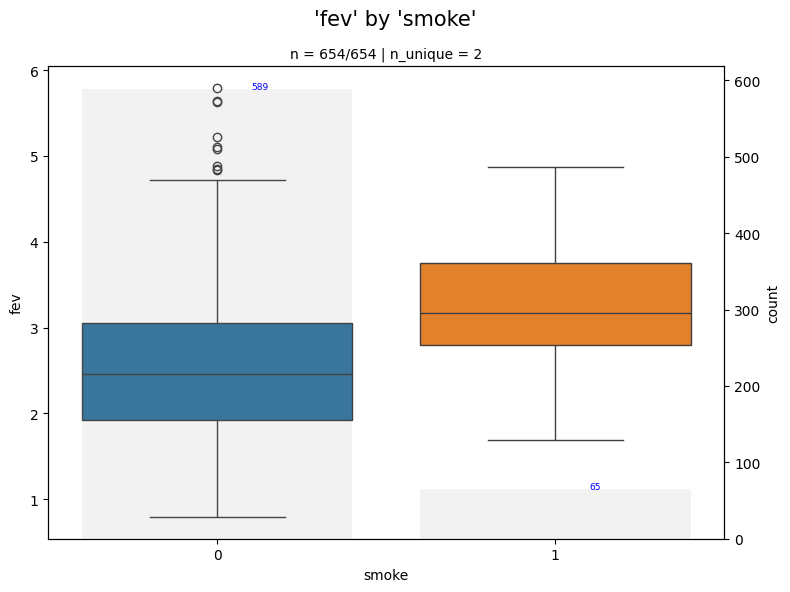

In [11]:
my.cat_num_plots(data=df, y='fev', x='smoke')

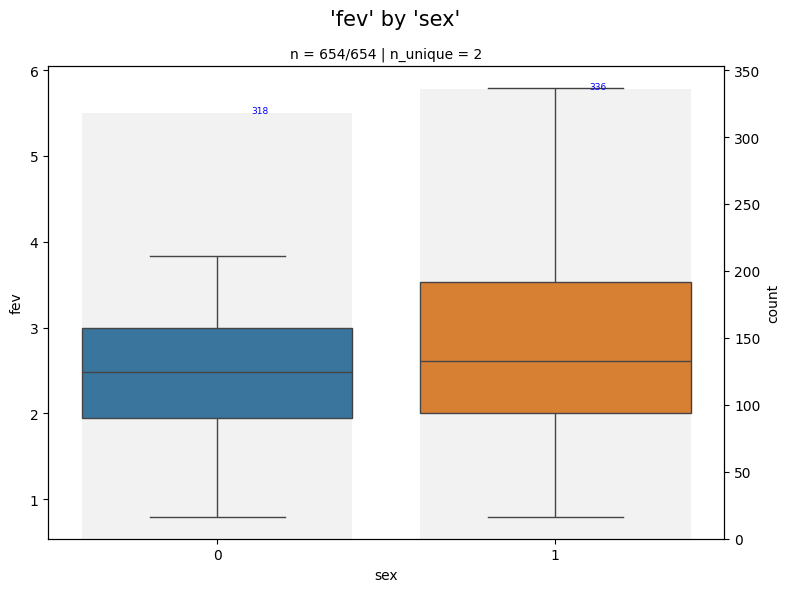

In [12]:
my.cat_num_plots(data=df, y='fev', x='sex')

¿Cuales son las 3 variables que elegirías para tu primer modelo de regresión en base a esta información?

**Respuesta**: <br>
- Dadas las pocas variables disponibles, si tuviera que elegir 3 de las 4 predictoras (excluyendo las dos variables de identificación), escogería `height`, `age`, y `smoke`, en ese orden de prioridad. ¿La fuerte relación positiva de las dos primeras con FEV se debe a la razón biológica del **desarrollo del sistema respiratorio de los niños con los años**, el cual resulta en mejores capacidades de los pulmones?
- Cabe mencionar que **la altura y la edad de los niños presentan una alta colinearidad de approx 0.79**. Se tendría que valorar con VIF si incluir las dos en una misma regresión.
- **sex de los niños no parece tener una gran importancia en fev**, el volumen espiratorio forzado.
- **Contraintuitivo que los niños que consuman tabaco tengan mejores capacidades pulmonares (según el FEV) que aquellos que no presentan dicho hábito**. No obstante, es difícil determinar el efecto real a nivel univariante y con el desbalance de muestras (solamente 65 de 654 niños fuman). Podría deberse también al retardo de los efectos negativos del tabaquismo en los pulmones. Estos efectos pueden ser acumulativos y presentarse a largo plazo, y es por ello que los niños que fuman no hayan experimentado estos efectos en el momento de la medición del FEV (**suposición personal**).

## Pregunta 3

Ajusta el modelo de regresión que contiene los 3 predictores que has decidido en el apartado anterior en el propio conjunto de entrenamiento (no hace falta hacer partición) y muestra el summary de dicho modelo. 

In [13]:
# Ajuste de modelo 
formula_base = 'fev ~ height + age + smoke'
# Summary
my.build_reg_model(model_type='ols', df=df, formula=formula_base)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     715.7
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          1.86e-205
Time:                        23:49:56   Log-Likelihood:                -356.98
No. Observations:                 654   AIC:                             722.0
Df Residuals:                     650   BIC:                             739.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6160      0.224    -20.618      0.000      -5.056      -4.176
smoke[T.1]    -0.1102      0.060     -1.837      0.067      -0.228       0.008
height         0.1091      0.005     23.115      0.000       0.100       0.118
age            0.0597      0.010      6.247      0.000       0.041       0.079
==============================================================================
Omnibus:                       31.673   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.104
Skew:                           0.292   Prob(JB):                     1.20e-14
Kurtosis:                       4.419   Cond. No.                         851.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
df.groupby(['smoke'])[['fev', 'age', 'height']].median().round(2)

,fev,age,height
smoke,,,
0,2.46,9.0,61.0
1,3.17,13.0,66.0


 A la vista de los valores de ajuste, ¿qué porcentaje de variabilidad explicada tiene el modelo? Interpreta el parámetro estimado de la *altura*.

**Respuesta**: <br>
- **El modelo explica cerca del 76.7%** (Adj. R-squared) de la variabilidad de la variable objetiva, FEV.
- **El aumento en la altura en un inch (2,54 cm)** está asociado a un incremento de approx 0.11 litros por segundo en el volumen respiratorio forzado (FEV).
- Interesante observar que **el efecto del tabaquismo en las capacidades pulmonares se ha vuelto negativo una vez controladas otras variables como la edad y la altura**, y es que al parecer el efecto positivo del tabaquismo en la variable objetivo, a nivel univariante, se debe en parte a que aquellos niños que fuman son también más altos y mayores que aquellos que no fuman en promedio. No obstante, el pvalor es mayor que 0.05 (0.067), así que **no ponemos fiarnos de si fumar realmente afecta al FEV en los niños a un nivel de significancia del 0.05**!

## Pregunta 4

Aplica validación cruzada repetida para tu modelo con nuestra querida función *cross_val_lin* y una semilla conformada por los 4 últimos dígitos de tu documento de identidad. Muestra el boxplot de sesgo-varianza de las estimaciones. 

Modelo: fev ~ height + age + smoke
Coeficiente de determinación R2: 0.763 (0.029)


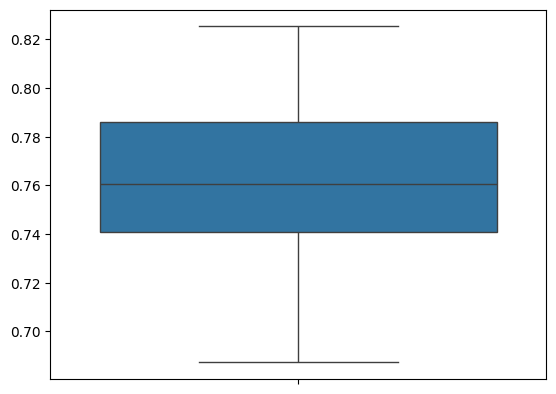

In [15]:
# Validación cruzada
rand_state = 1096
scores = clase.cross_val_lin(formula=formula_base, data=df, seed=rand_state)
# Boxplot sesgo-varianza
sns.boxplot(y=scores)
plt.show()

A la vista de los resultados. ¿Está sobreajustando tu modelo al conjunto de entrenamiento?

**Respuesta**: <br>
- Dado que el R2 medio de los 100 modelos es de 0.763 con una desviación típica media de 0.029, **podemos afirmar con cierta confianza de que dicho modelo presenta una baja varianza**, y por lo tanto, no hay indicios de sobreajuste al conjunto de entrenamiento.
- Estaría mucho mejor, desde luego, comprobar dicho modelo en el conjunto de prueba después de realizar la partición de la muestra.

## Pregunta 5

Indica el código necesario para leer el conjunto de datos **"IPI_Esp.xlsx"** y muestra su cabeza.

In [43]:
# Lectura de datos IPI
df_ipi = pd.read_excel(r"C:\Users\milow\Desktop\Máster_UCM\1.Módulos\6.Minería_Datos\4.Tarea\Práctica Python\Datos\IPI_Esp.xlsx")
# Primeras filas
df_ipi.head()

,Date,IPI Nacional
0,1975M01,70.658
1,1975M02,72.180
2,1975M03,75.732
3,1975M04,74.844
4,1975M05,74.210


In [44]:
df_ipi.shape

(539, 2)

## Pregunta 6

Convierte el conjunto en una serie temporal legible para Python y representa gráficamente la evolución. 

In [45]:
# Conversión a serie temporal legible
df_ipi['Date'] = df_ipi['Date'].str.replace('M', '-')
df_ipi['Date']

0          1975-01
1          1975-02
2          1975-03
3          1975-04
4          1975-05
          ...     
534        2019-07
535        2019-08
536        2019-09
537        2019-10
538        2019-11
Name: Date, Length: 539, dtype: object

In [46]:
# Convertir en date-time
df_ipi['Date'] = pd.to_datetime(df_ipi['Date'])
df_ipi['Date']

0     1975-01-01
1     1975-02-01
2     1975-03-01
3     1975-04-01
4     1975-05-01
         ...    
534   2019-07-01
535   2019-08-01
536   2019-09-01
537   2019-10-01
538   2019-11-01
Name: Date, Length: 539, dtype: datetime64[ns]

In [47]:
# Mostrar valores de serie
df_ipi.set_index('Date', drop=True, inplace=True)
df_ipi.index.freq = 'MS'  # La función infiere que los datos se han tomado al inicio de cada mes
df_ipi

,IPI Nacional
Date,
1975-01-01,70.658
1975-02-01,72.180
1975-03-01,75.732
1975-04-01,74.844
1975-05-01,74.210
...,...
2019-07-01,114.698
2019-08-01,85.929
2019-09-01,106.408


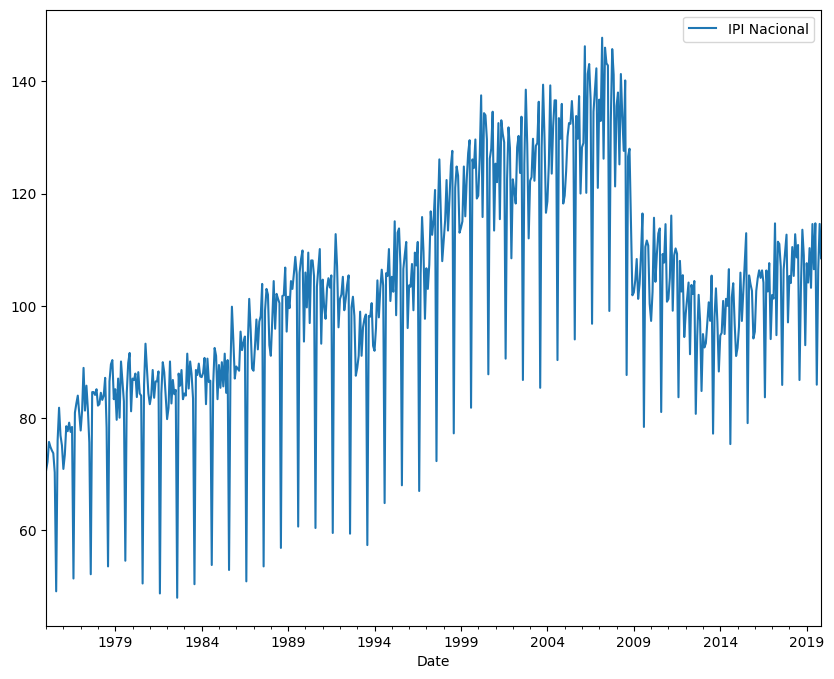

In [50]:
# Gráfico de evolución del IPI
plt.rcParams['figure.figsize'] = (10, 8)

df_ipi.plot()
plt.show()

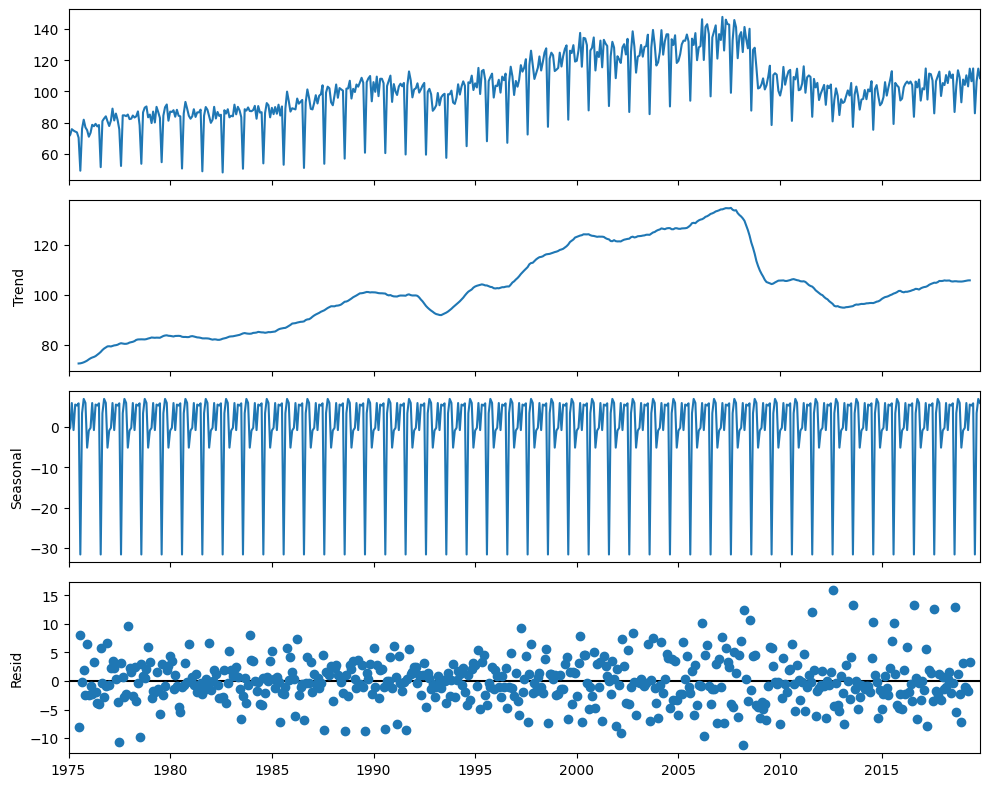

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df_ipi).plot()
plt.show()

¿Qué componentes de la serie se pueden intuir en el gráfico?

**Respuesta**: <br>
- Se observa la presencia de **tendencias cambiantes** (no es constante) y una **fuerte estacionalidada** lo largo de los años!
- Además, al parecer **la volatilidad ha disminuido considerablemente a partir del año 2009** incluido en adelante. Quizás tomar el logaritmo de la  series sería una buena idea para estabilizar la varianza.

## Pregunta 7

Toma una partición con ventana de entrenamiento (todo el histórico hasta diciembre de 2017) y prueba (2018 y 2019). Ajusta el modelo de suavizado que consideres más adecuado a la luz de las características de la serie. Evalua el modelo en términos de error y adecuación de los residuos. ¿El modelo satisface las condiciones residuales en cuanto a  autocorrelaciones?

In [52]:
# Partición de datos
X_train = df_ipi[:'2017']
X_test = df_ipi['2018':]

(X_train.shape, X_test.shape)

((516, 1), (23, 1))

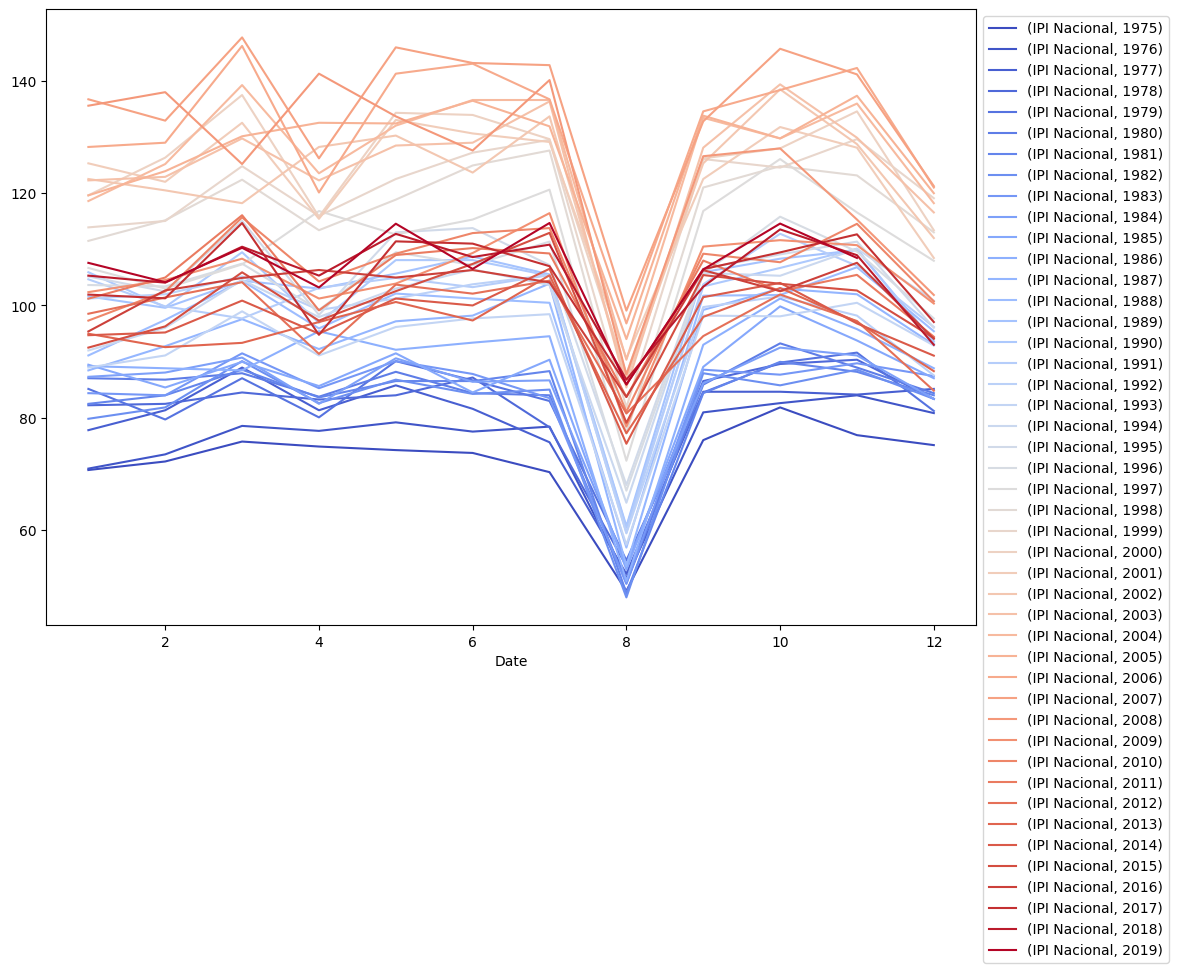

In [53]:
my.seasonal_plot(df_ipi)  # estacionalidad mensual: m=12!

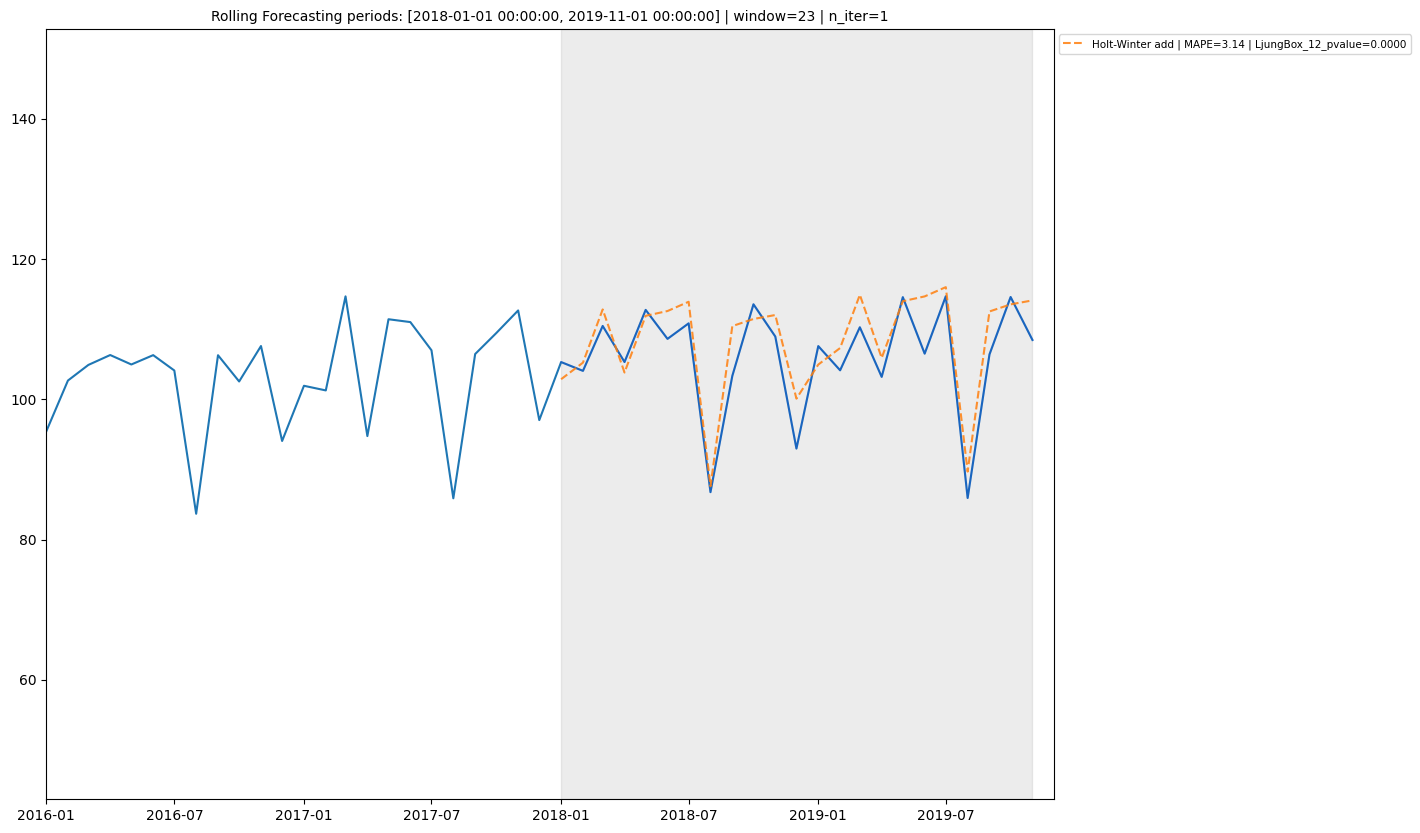

In [54]:
# Ajuste de modelo de suavizado
_, ax = plt.subplots(figsize=(13,10))

ax.plot(df_ipi)

# Holt-Winter's Exponential Smoothing: modelo aditivo!
my.rolling_forecast(model_type='holt-winter', df_ts=df_ipi, X_train=X_train, X_test=X_test, model_name='Holt-Winter add',
                    eval_metric='mape', hw_seasonal_periods=12, hw_seasonal='add', ax=ax)

ax.set_xlim(left=pd.Timestamp('2016-01'), right=pd.Timestamp('2019-12'))
plt.show()

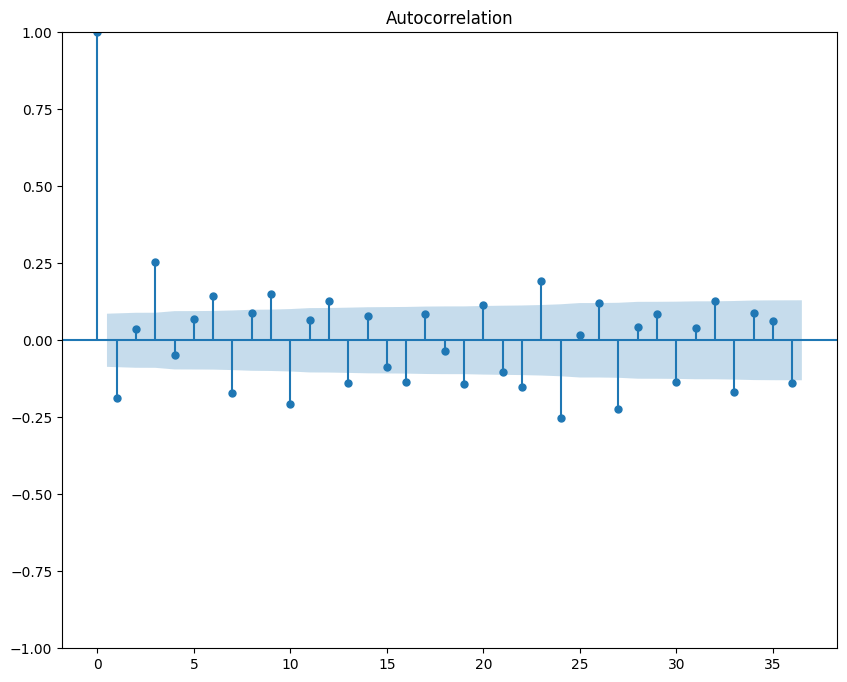

In [55]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

hw_model = my.rolling_forecast(model_type='holt-winter', df_ts=df_ipi, X_train=X_train, X_test=X_test, model_name='Holt-Winter add',
                    eval_metric='mape', hw_seasonal_periods=12, hw_seasonal='add', return_type='model')

plot_acf(hw_model.resid, lags=36)
plt.show()

**Respuesta**: <br>
- El modelo de suavizado utilizado es el de **Holt-Winter** ya que la serie temporal tiene ambos componentes tanto tendencia como estacionalidad.
- Las prediciones de dicho modelo presenta un error promedio **(MAPE) del approx 3.14%**.
- Sin embargo, los residuos de dicho modelo no se asemeja a un ruido blanco: el pvalue del test de Ljun-box es menor que 0.05 (0), **rechazando la hipótesis nula de no autocorrelación (12 lags)**.
- Observando la función de autocorrelación, vemos que **muchos lags con correlaciones estadísticamente significativas**!

## Pregunta 8

Presenta los correlogramas simple y parcial de la serie diferenciada en lo regular y estacional para el conjunto de entrenamiento. 

In [56]:
# Prueba antes de diferenciar: no estacionario!
my.test_stationarity(X_train)

P-value for Augmented Dickey-Fuller test: 0.41230
There is no enough evidence to reject H0 at a 0.05 level.
Given time series has a unit root; it is Not stationary!


P-value for Augmented Dickey-Fuller test: 0.00000
There is evidence to reject H0 at a 0.05 level.
Given time series does not have a unit root; it is stationary!


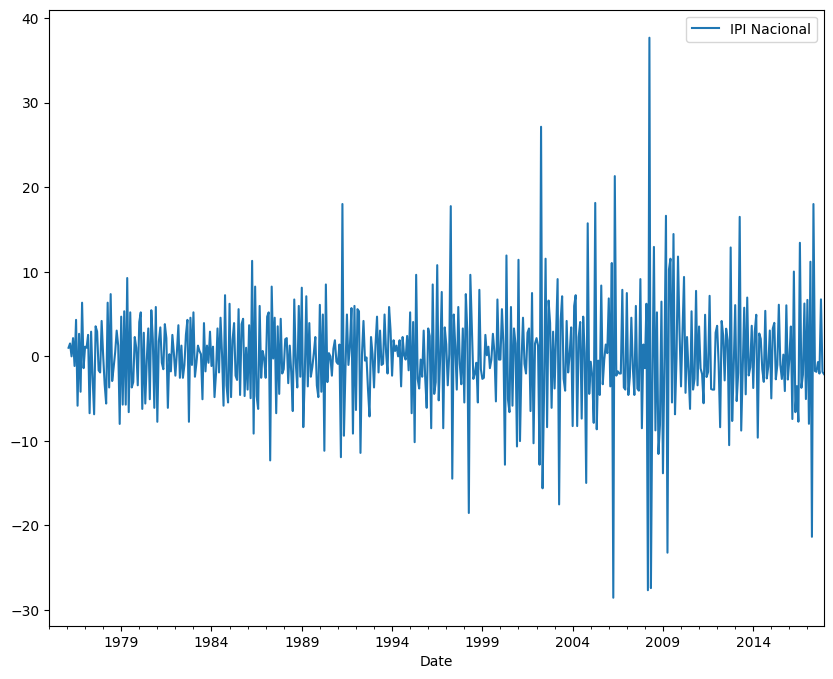

In [57]:
# Diferenciar serie
# Diferenciación regular + estacional -> estacionaria, por lo tanto d=D=1!
X_train_diff_1_12 = X_train.diff(periods=1).diff(periods=12)
my.test_stationarity(X_train_diff_1_12.dropna())

X_train_diff_1_12.plot();

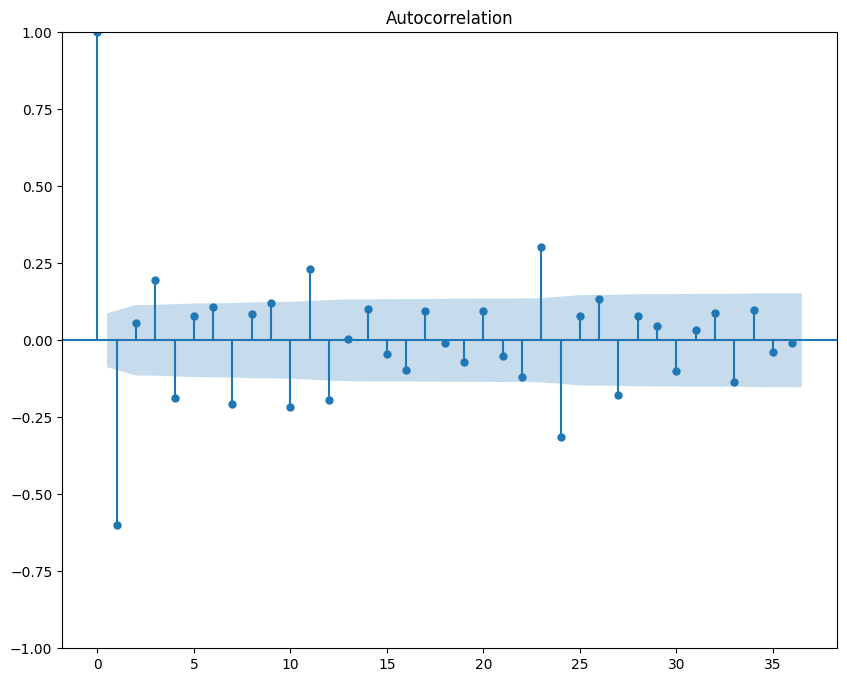

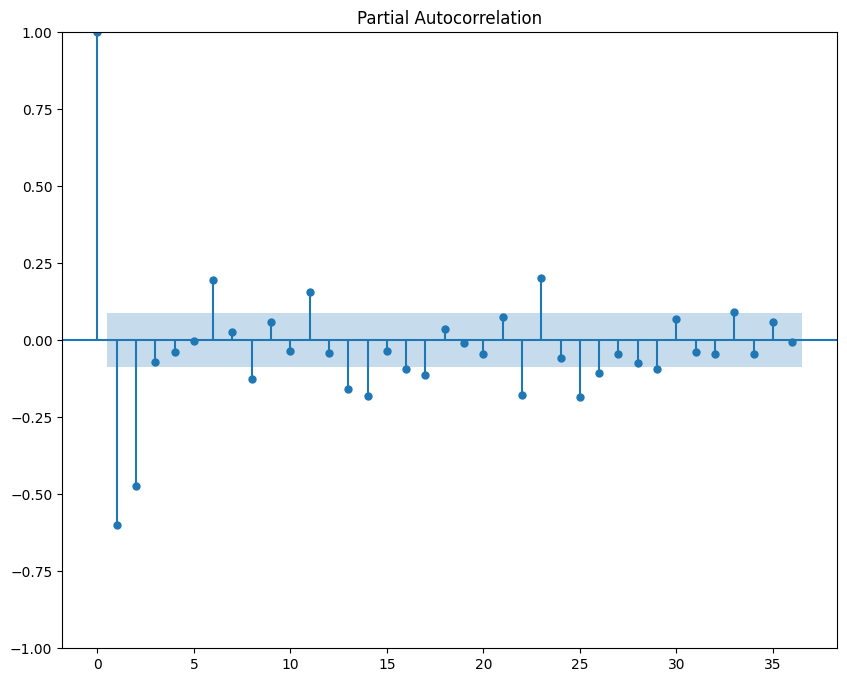

In [58]:
# Correlograma simple ACF
plot_acf(X_train_diff_1_12.dropna(), lags=36)
# Correlograma parcial PACF
plot_pacf(X_train_diff_1_12.dropna(), lags=36)
plt.show()

A pesar de la dificultad, intentemos proponer algunos órdenes en lo regular y estacional para un tentativo modelo arima. 

¿Cual sería tu primer modelo a probar según lo que observas en la desaparición de las correlaciones con los retardos?

**Respuesta**: Mi modelo sería ARIMA(p,d,q)(P,D,Q) <br>
- Mi model sería: `ARIMA(2,1,1)(2,1,1)[12]`

## Pregunta 9

Ajusta ese modelo que propones y evalúa su capacidad de ajuste en test y la adecuación de residuos. 

In [59]:
# Ajuste y Summary del modelo 
model_manual_arima = my.rolling_forecast(model_type='sarimax', df_ts=df_ipi, X_train=X_train, X_test=X_test,
                    model_name='ARIMA(2,1,1)(2,1,1)[12]', eval_metric='mape',
                    order=(2,1,1), seasonal_order=(2,1,1,12), return_type='model')

model_manual_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       IPI Nacional   No. Observations:                  516
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1410.996
Date:                            Sun, 04 Feb 2024   AIC                           2835.993
Time:                                    23:59:04   BIC                           2865.537
Sample:                                01-01-1975   HQIC                          2847.583
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6367      0.088     -7.272      0.000      -0.808      -0.465
ar.L2         -0.3321      0.062     -5.398      0.000      -0.453      -0.212
ma.L1         -0.2631      0.080     -3.272      0.001      -0.421      -0.105
ar.S.L12       0.1418      0.076      1.877      0.060      -0.006       0.290
ar.S.L24      -0.2382      0.047     -5.115      0.000      -0.329      -0.147
ma.S.L12      -0.6558      0.061    -10.669      0.000      -0.776      -0.535
sigma2        15.7002      0.709     22.147      0.000      14.311      17.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               125.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

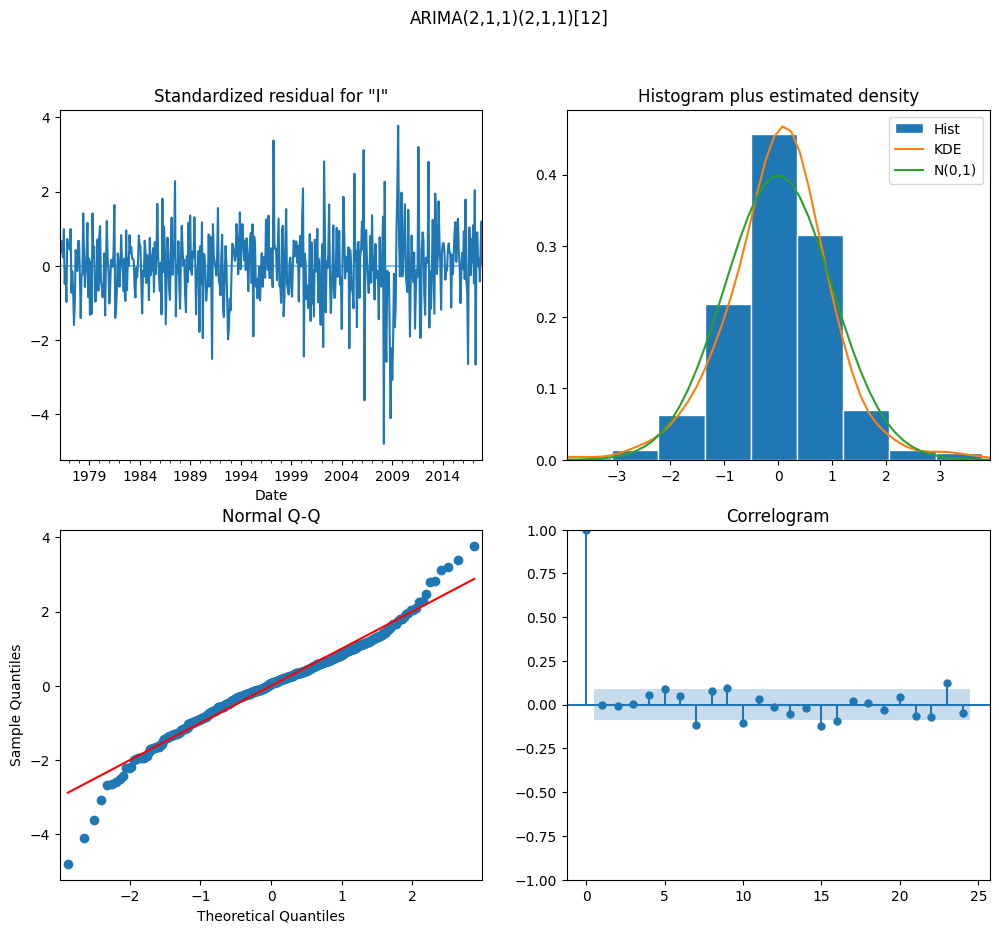

In [60]:
my.rolling_forecast(model_type='sarimax', df_ts=df_ipi, X_train=X_train, X_test=X_test,
                    model_name='ARIMA(2,1,1)(2,1,1)[12]', eval_metric='mape',
                    order=(2,1,1), seasonal_order=(2,1,1,12), return_type='diagnostics')

¿Son todos los efectos significativos en el modelo?

**Respuesta**: <br>
- Sorprendentemente todos los efectos son significativos, a excepción del componente autoregresivo de orden 1 en el orden estacional! 

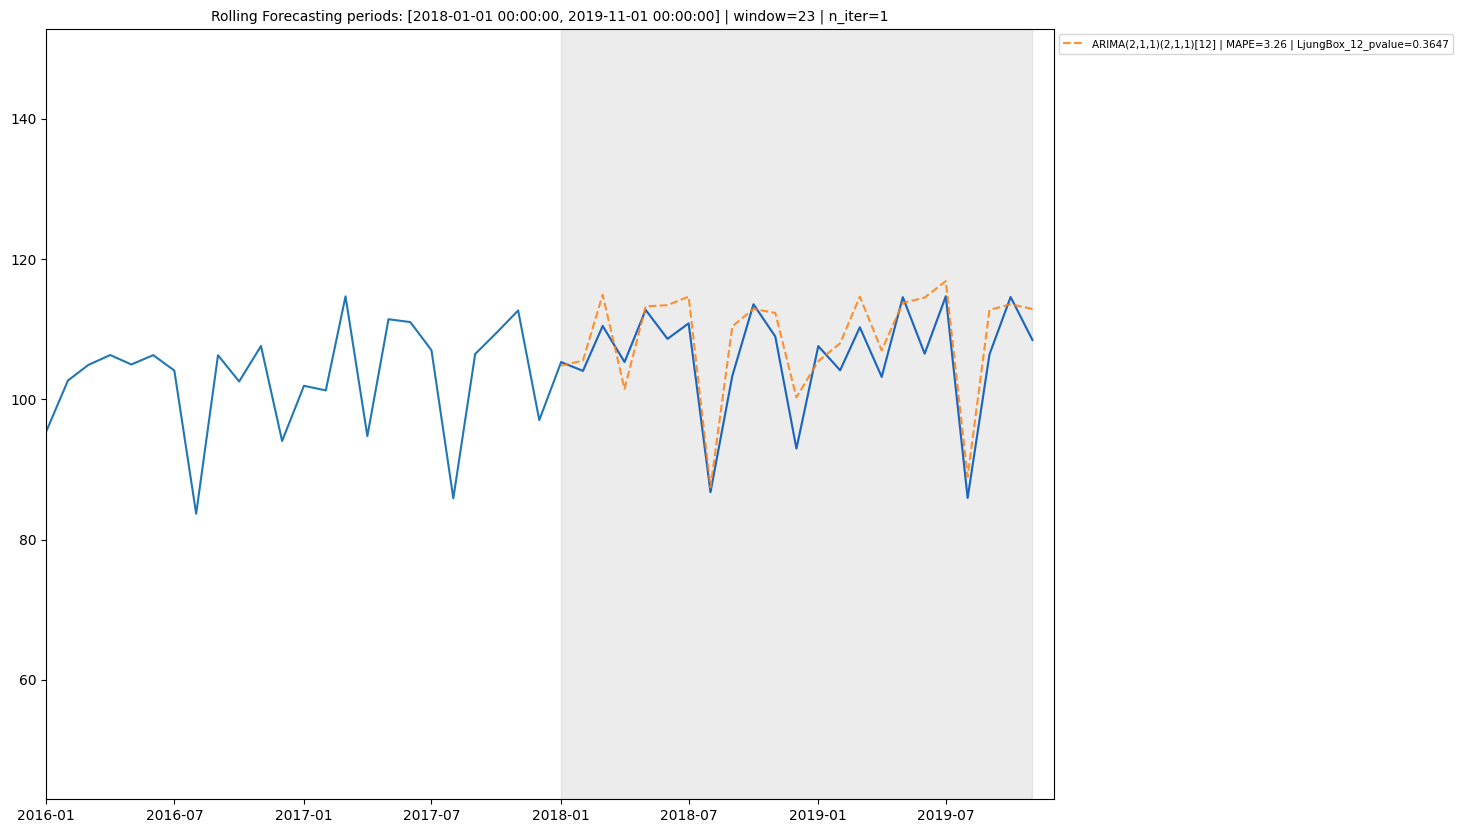

In [61]:
# Evaluación del modelo (eval_model)
_, ax = plt.subplots(figsize=(13,10))

ax.plot(df_ipi)

my.rolling_forecast(model_type='sarimax', df_ts=df_ipi, X_train=X_train, X_test=X_test,
                    model_name='ARIMA(2,1,1)(2,1,1)[12]', eval_metric='mape',
                    order=(2,1,1), seasonal_order=(2,1,1,12), ax=ax)

ax.set_xlim(left=pd.Timestamp('2016-01'), right=pd.Timestamp('2019-12'))
plt.show()

¿Es tu modelo válido para la predicción en términos de adecuación residual? En caso contrario, juega con los órdenes para obtener un modelo que satisfaga el test de residuos. ¿Es este modelo aceptable mejor que el suavizado en términos de capacidad de predicción en el conjunto de test? 

**Respuesta**: <br>
- En cuanto al test de autocorrelación de Ljun-Box con la media de los 12 retardos, el valor 0.36 del pvalue indica que dicho modelo no presenta autocorrelación. No obstante, los residuos no tienen pinta de ser normales por la presencia de atípicos en ambas direcciones (forzadamente normal).
- En cuanto a capacidad de predicción, mi modelo ARIMA(2,1,1)(2,1,1)[12] tiene un error (MAPE) de 3.26 > 3.14, lo cual es ligeramente peor que el modelo suavizado de Holt-Winter. Elegiríamos ARIMA(2,1,1)(2,1,1)[12] por la ligera diferencia en capacidad predictiva relativa y mejores residuos!

In [62]:
# Buscar el mejor modelo por autoarima (exhaustiva con max p/P y q/Q = 2)
# 81 combinaciones!
my.optimize_SARIMAX(X_train=X_train, max_p=2, max_q=2, d=1,
                    seasonal=True, m=12, max_P=2, max_Q=2, D=1,
                    return_type='model')

  0%|          | 0/81 [00:00<?, ?it/s]

   SARIMAX(p,d,q)(P,D,Q)[m]          AIC
0    (2, 1, 1)(2, 1, 2)[12]  2834.330238
1    (2, 1, 1)(1, 1, 2)[12]  2834.728912
2    (2, 1, 1)(2, 1, 1)[12]  2835.992971
3    (2, 1, 2)(2, 1, 2)[12]  2836.268230
4    (2, 1, 2)(1, 1, 2)[12]  2836.691358
..                      ...          ...
76   (0, 1, 0)(1, 1, 1)[12]  3190.989469
77   (0, 1, 0)(0, 1, 1)[12]  3213.758793
78   (0, 1, 0)(2, 1, 0)[12]  3239.050824
79   (0, 1, 0)(1, 1, 0)[12]  3311.022472
80   (0, 1, 0)(0, 1, 0)[12]  3328.762718

[81 rows x 2 columns]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            IPI Nacional   No. Observations:                  516
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1409.165
Date:                                 Mon, 05 Feb 2024   AIC                           2834.330
Time:                                         00:00:40   BIC                           2868.095
Sample:                                     01-01-1975   HQIC                          2847.576
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6732      0.088     -7.619      0.000      -0.846      -0.500
ar.L2         -0.3582      0.062     -5.743      0.000      -0.480      -0.236
ma.L1         -0.2274      0.082     -2.773      0.006      -0.388      -0.067
ar.S.L12      -0.3485      0.136     -2.570      0.010      -0.614      -0.083
ar.S.L24      -0.1063      0.084     -1.270      0.204      -0.270       0.058
ma.S.L12      -0.1412      0.130     -1.089      0.276      -0.395       0.113
ma.S.L24      -0.4022      0.119     -3.382      0.001      -0.635      -0.169
sigma2        15.5894      0.743     20.976      0.000      14.133      17.046
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                98.23
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Escogemos `ARIMA(2, 1, 1)(1, 1, 2)[12]` el segundo mejor basado en AIC ya que la diferencia con el mejor es mínima y tiene menos parámetros!
- Nótese que el **modelo manual escogido por mí es el tercer mejor**: `ARIMA(2, 1, 1)(2, 1, 1)[12]` con AIC 2835.992971.
>- Pura suerte, aún así orgulloso jeje :)

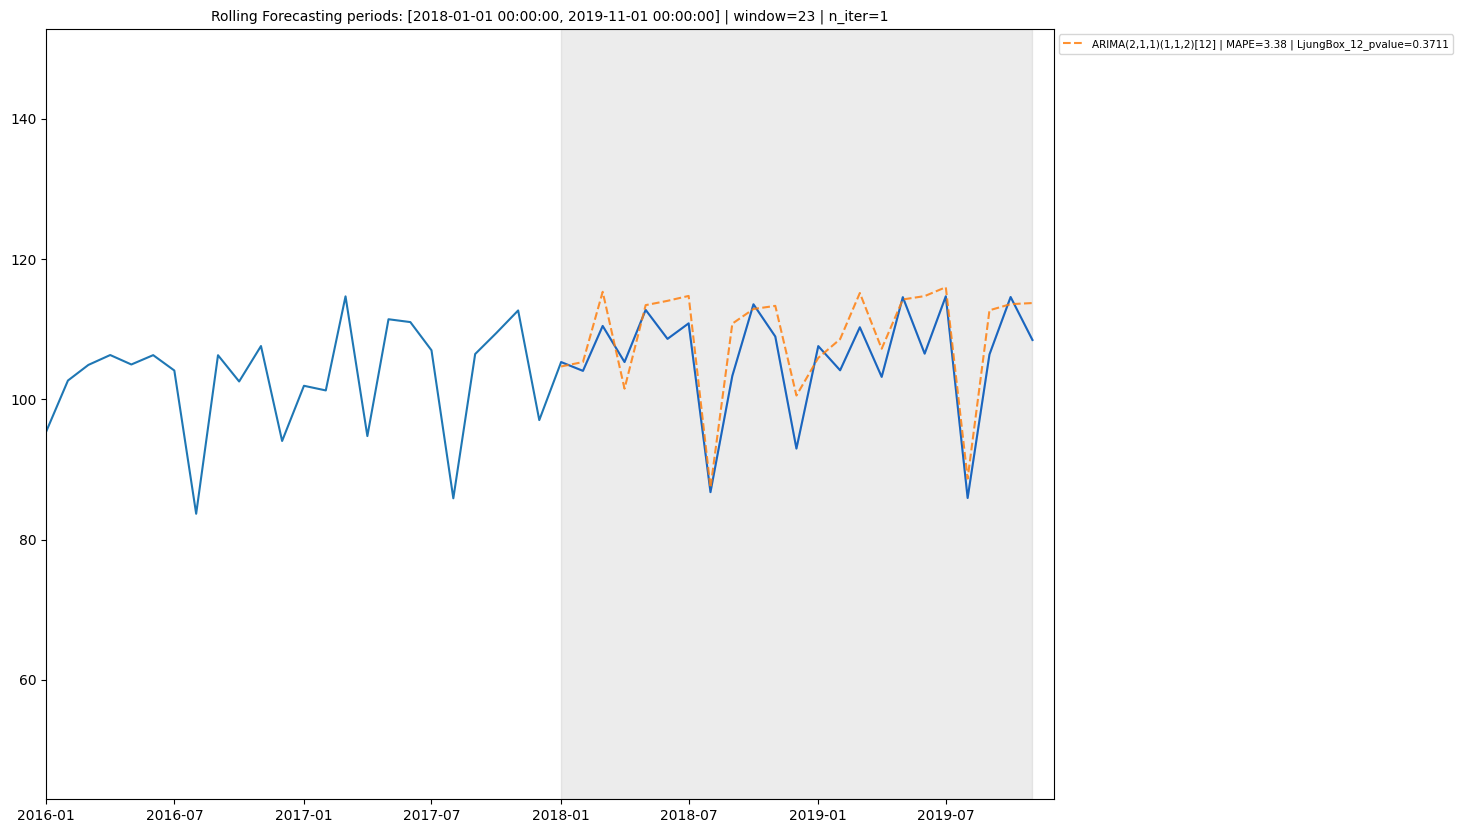

In [76]:
# Evaluación del mejor modelo autoarima
_, ax = plt.subplots(figsize=(13,10))

ax.plot(df_ipi)

my.rolling_forecast(model_type='sarimax', df_ts=df_ipi, X_train=X_train, X_test=X_test,
                    model_name='ARIMA(2,1,1)(1,1,2)[12]', eval_metric='mape',
                    order=(2,1,1), seasonal_order=(1,1,2,12), ax=ax)

ax.set_xlim(left=pd.Timestamp('2016-01'), right=pd.Timestamp('2019-12'))
plt.show()

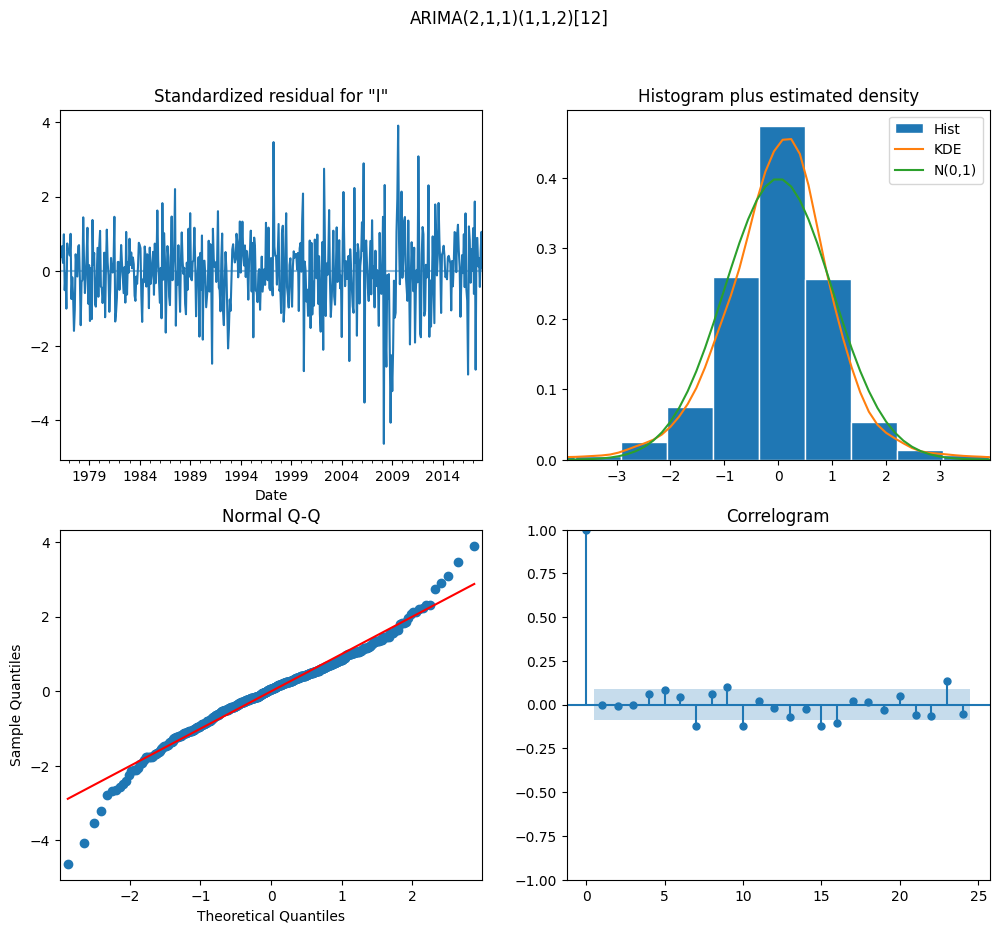

In [75]:
my.rolling_forecast(model_type='sarimax', df_ts=df_ipi, X_train=X_train, X_test=X_test,
                    model_name='ARIMA(2,1,1)(1,1,2)[12]', eval_metric='mape',
                    order=(2,1,1), seasonal_order=(1,1,2,12), return_type='diagnostics')

- El mejor modelo autoarima `ARIMA(2, 1, 1)(1, 1, 2)[12]` tiene mejores autocorrelaciones con un pvalue en Ljun-Box de 0.37 > 0.36 que mi modelo `ARIMA(2, 1, 1)(2, 1, 1)[12]` aunque a nivel predictivo mi modelo es mejor: MAPE 3.26 < 3.38.

## Pregunta 10

Indica el código necesario para leer el archivo **"clientes_cluster.csv"** y mostrar sus primeros registros. 

In [2]:
# Lectura clientes_cluster
df_clientes = pd.read_csv(r"C:\Users\milow\Desktop\Máster_UCM\1.Módulos\6.Minería_Datos\4.Tarea\Práctica Python\Datos\clientes_cluster.csv")
df_clientes

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,15.0,NaN
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,NaN
4,5,Female,31.0,NaN,40.0
...,...,...,...,...,...
195,196,Female,35.0,120.0,79.0
196,197,Female,45.0,126.0,28.0
197,198,Male,32.0,126.0,74.0
198,199,Male,32.0,137.0,18.0


## Pregunta 11

Evalúa la incidencia de valores perdidos por variable e imputa el archivo mediante el método multivariante basado en el algoritmo Iterativo por cadenas de Markov (IterativeImputer), generando un nuevo archivo completo **"clientes_imputed"** del que se mostrará la información para comprobar que efectivamente todos los registros contienen valores válidos.

In [3]:
#Incidencia de missings por variable
df_clientes.isna().sum()

CustomerID                 0
Gender                    15
Age                       13
Annual Income (k$)         9
Spending Score (1-100)    18
dtype: int64

In [4]:
df_clientes.isna().mean().mul(100)

CustomerID                0.0
Gender                    7.5
Age                       6.5
Annual Income (k$)        4.5
Spending Score (1-100)    9.0
dtype: float64

**Comentario**: <br>
- Presencia de valores perdidos en todas las características, exceptuando la variable de identificación.
- La incidencia máxima por variable es del 9%. Tampoco es alarmante.
- Sería interesante investigar también los valores perdidos por registros ya que si para un mismo registro, las 4 características están missing, no habría otra alternativa que eliminarlas del conjunto...
- Antes de imputar los missings, se tendrá que que evaluar también cómo éstos están distribuidos por el conjunto; desearíamos que fueran aleatorios.

In [3]:
# Separamos la columna de identificación
X = df_clientes.drop(columns='CustomerID')

print(X['Gender'].value_counts(sort=False))

# Recodificar Male como 1 y Female como 0
#de cara a la imputación
X['Gender'].replace(['Male', 'Female'], [1, 0], inplace=True)
print(X['Gender'].value_counts(sort=False))

Gender
Male       83
Female    102
Name: count, dtype: int64
Gender
1.0     83
0.0    102
Name: count, dtype: int64


In [4]:
# Imputación multivariante Iterativa
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(missing_values=np.nan)
clientes_imputed_iter = pd.DataFrame(iter_imputer.fit_transform(X),
                                     columns=X.columns)

# Info del archivo imputado
clientes_imputed_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  200 non-null    float64
 1   Age                     200 non-null    float64
 2   Annual Income (k$)      200 non-null    float64
 3   Spending Score (1-100)  200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [7]:
# Comparar df antes de imputación vs df después de imputacuón
my.compare_dfs(X, clientes_imputed_iter)

'Gender' has different unique values (diff length | capped to 15 values):
	df1 (3): [1.0, 0.0, nan]
	df2 (17): [1.0, 0.0, 0.42878937135257605, 0.42184813991139136, 0.4400449916654969, 0.44555450021053844, 0.44921112887235215, 0.4458178859248404, 0.44891152885200447, 0.44074129785210614, 0.4533431847840595, 0.4657224999043747, 0.4503425458380892, 0.46536019740515167, 0.45045128749910085]
'Gender' values differ from each other at index and values:
	----df1----
9     NaN
11    NaN
24    NaN
54    NaN
59    NaN
63    NaN
73    NaN
84    NaN
98    NaN
130   NaN
132   NaN
166   NaN
169   NaN
174   NaN
183   NaN
Name: Gender, dtype: float64
	----df2----
9      0.428789
11     0.421848
24     0.440045
54     0.445555
59     0.449211
63     0.445818
73     0.448912
84     0.440741
98     0.453343
130    0.465722
132    0.450343
166    0.465360
169    0.450451
174    0.461005
183    0.445265
Name: Gender, dtype: float64

'Age' has different unique values (diff length | capped to 15 values):
	df1

In [5]:
# Observamos números reales con decimales en variables: Age y Gender
# Forzamos la conversión a números enteros con np.round:
clientes_imputed_iter[['Gender', 'Age']] = np.round(clientes_imputed_iter[['Gender', 'Age']])
my.compare_dfs(X[['Gender', 'Age']], clientes_imputed_iter[['Gender', 'Age']]) # Comprobamos...

'Gender' has different unique values (diff length | capped to 15 values):
	df1 (3): [1.0, 0.0, nan]
	df2 (2): [1.0, 0.0]
'Gender' values differ from each other at index and values:
	----df1----
9     NaN
11    NaN
24    NaN
54    NaN
59    NaN
63    NaN
73    NaN
84    NaN
98    NaN
130   NaN
132   NaN
166   NaN
169   NaN
174   NaN
183   NaN
Name: Gender, dtype: float64
	----df2----
9      0.0
11     0.0
24     0.0
54     0.0
59     0.0
63     0.0
73     0.0
84     0.0
98     0.0
130    0.0
132    0.0
166    0.0
169    0.0
174    0.0
183    0.0
Name: Gender, dtype: float64

'Age' has different unique values (diff length | capped to 15 values):
	df1 (52): [19.0, 21.0, 20.0, 23.0, 31.0, 22.0, 35.0, 64.0, 30.0, 67.0, 58.0, 24.0, 37.0, 52.0, 25.0]
	df2 (51): [19.0, 21.0, 20.0, 23.0, 31.0, 22.0, 35.0, 64.0, 30.0, 67.0, 58.0, 24.0, 37.0, 52.0, 25.0]
'Age' values differ from each other at index and values:
	----df1----
24    NaN
25    NaN
29    NaN
54    NaN
58    NaN
60    NaN
68    NaN
81  

Recodifica *Gender* como una variable dummy (cualquier opción de código es bienvenida) en formato numérico y elimina el ID de cliente de cara al análisis.

In [6]:
# Recodificación de Gender como dummy
clientes_imputed_iter

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,19.0,15.000000,39.000000
1,1.0,21.0,15.000000,58.152762
2,0.0,20.0,16.000000,6.000000
3,0.0,23.0,16.000000,57.140722
4,0.0,31.0,60.584794,40.000000
...,...,...,...,...
195,0.0,35.0,120.000000,79.000000
196,0.0,45.0,126.000000,28.000000
197,1.0,32.0,126.000000,74.000000
198,1.0,32.0,137.000000,18.000000


## Pregunta 12

Explora los métodos de clustering jerárquico para formar grupos de clientes similares en cuanto a su comportamiento en estas 4 variables disponibles y presenta sus dendogramas. Si lo consideras necesario, escala los datos previamente.

In [7]:
# Separar la columna dummy
X_cont = clientes_imputed_iter.drop(columns='Gender')

# Vamos a escalar las variables continuas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_cont_sc = pd.DataFrame(scaler.fit_transform(X_cont),
                         columns=X_cont.columns)

# Unir datos escalados con Gender dummy:
X_sc = pd.concat([X_cont_sc, clientes_imputed_iter['Gender']], axis=1)
X_sc

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.466169,-1.759225,-0.463419,1.0
1,-1.315831,-1.759225,0.321476,1.0
2,-1.391000,-1.720638,-1.815783,0.0
3,-1.165493,-1.720638,0.280001,0.0
4,-0.564142,-0.000257,-0.422438,0.0
...,...,...,...,...
195,-0.263467,2.292382,1.175811,0.0
196,0.488222,2.523902,-0.914207,0.0
197,-0.488973,2.523902,0.970907,1.0
198,-0.488973,2.948356,-1.324014,1.0


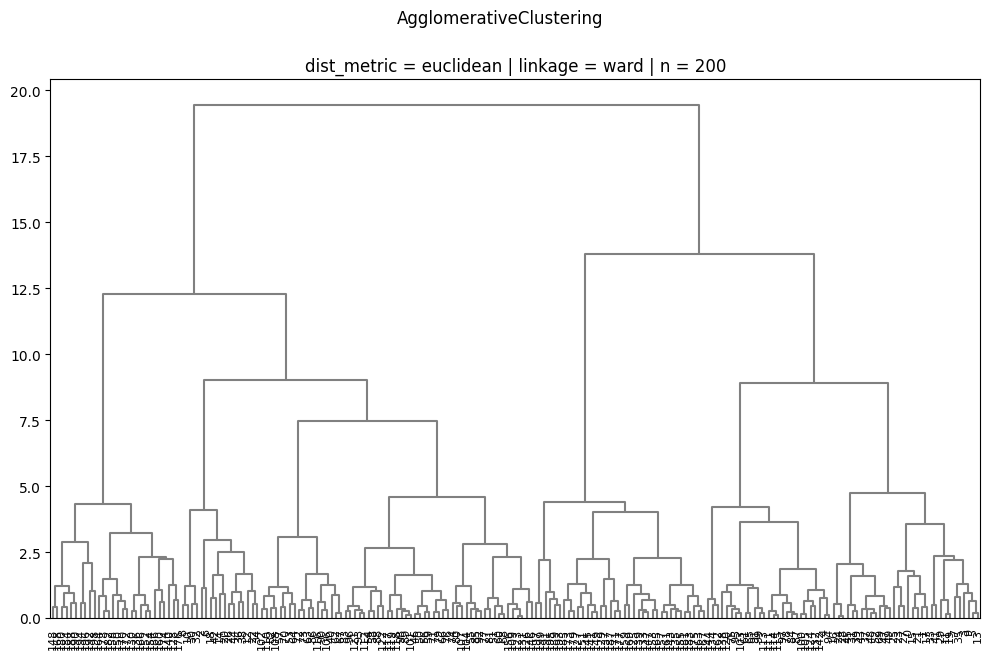

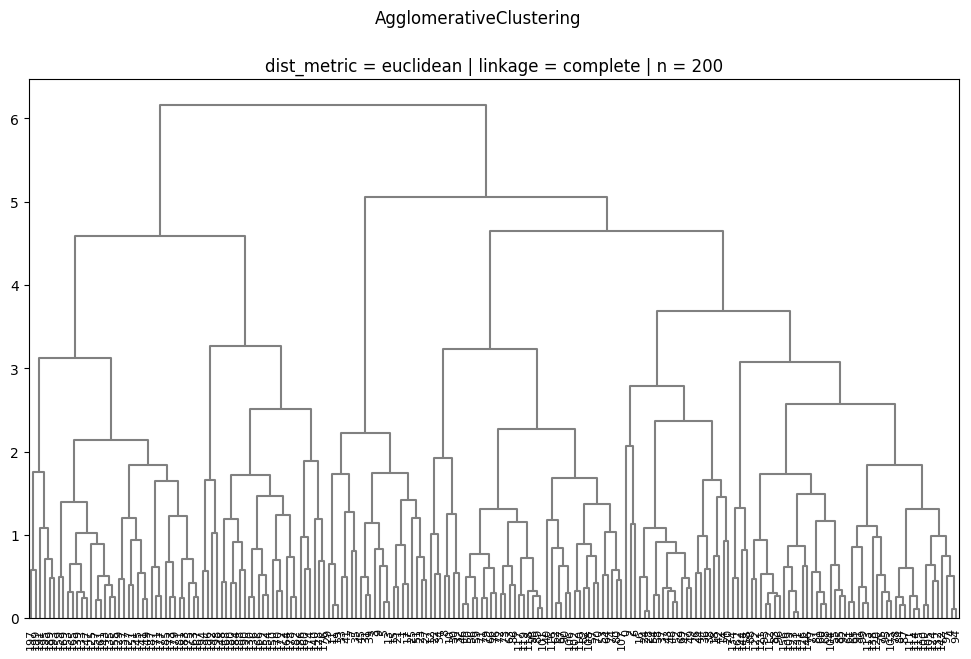

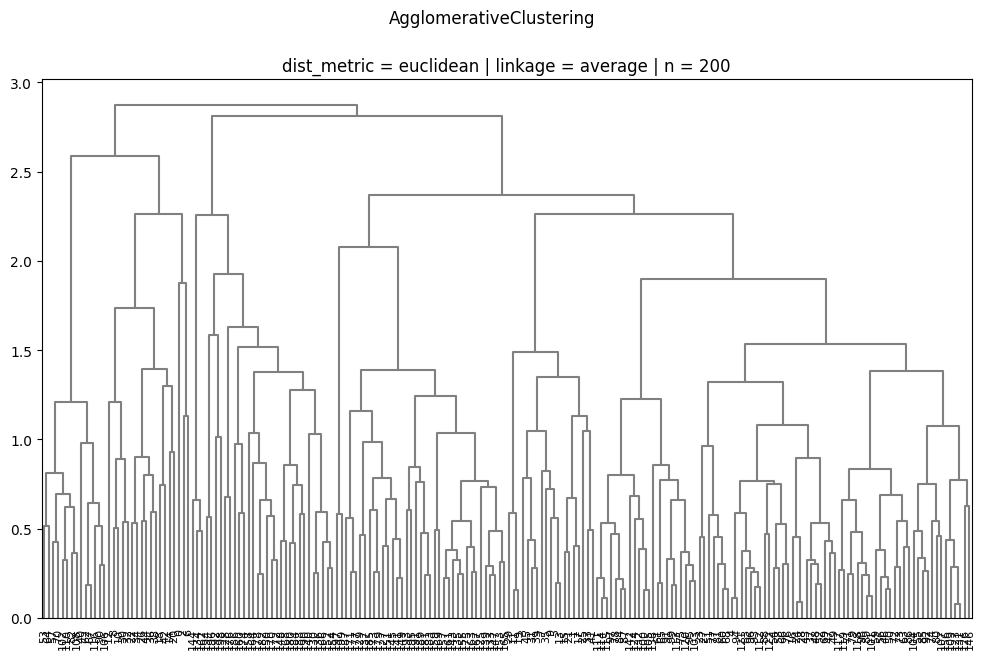

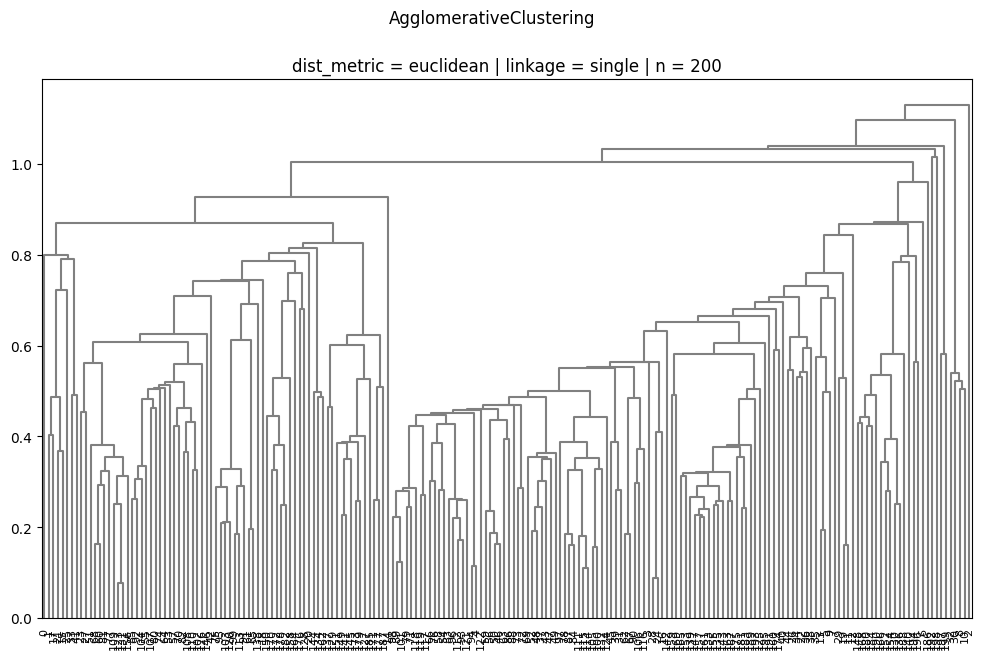

In [11]:
# Clustering jerárquico bucle de dendogramas
from sklearn.cluster import AgglomerativeClustering

linkages = ['ward', 'complete', 'average', 'single']
for linkage in linkages:
    hier_clustering = AgglomerativeClustering(compute_distances=True,
                                              metric='euclidean',
                                              linkage=linkage)
    hier_clustering.fit(X_sc)

    my.dendrogram_plot(hier_clustering)

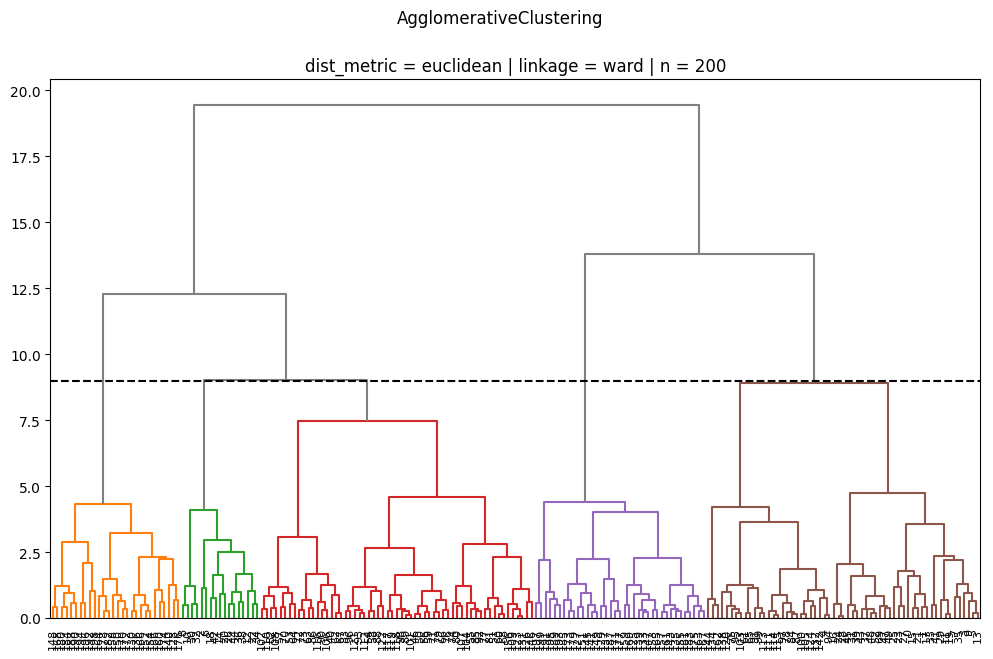

In [13]:
hier_clustering = AgglomerativeClustering(compute_distances=True,
                                            metric='euclidean',
                                            linkage='ward')
hier_clustering.fit(X_sc)

my.dendrogram_plot(hier_clustering, distance_threshold=9)

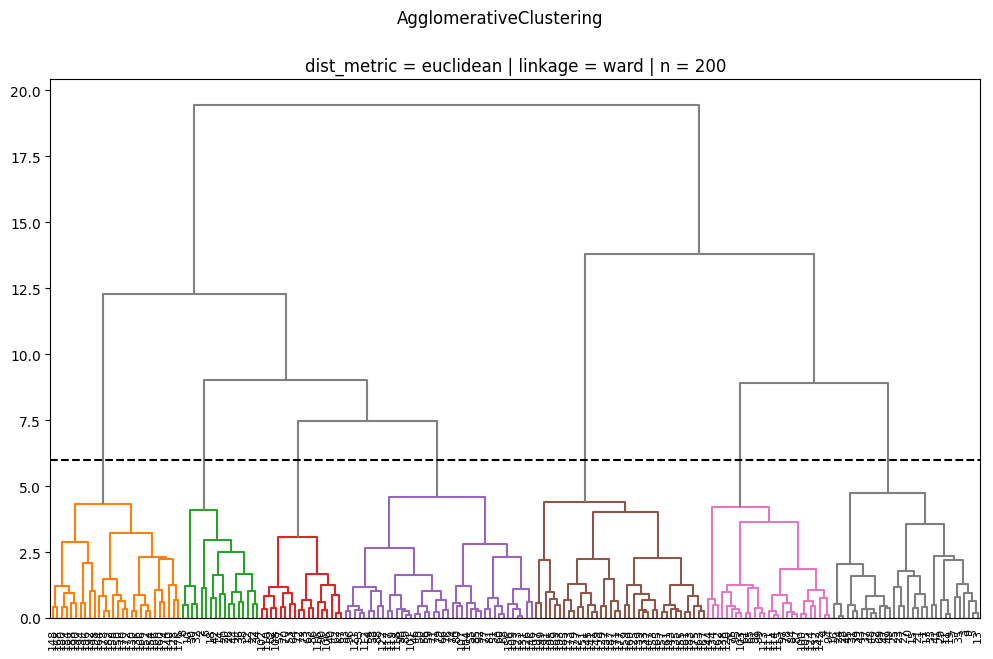

In [14]:
hier_clustering = AgglomerativeClustering(compute_distances=True,
                                            metric='euclidean',
                                            linkage='ward')
hier_clustering.fit(X_sc)

my.dendrogram_plot(hier_clustering, distance_threshold=6)

¿Cuál es el método de linkage más adecuado a la vista de los dendogramas? ¿Cuantos grupos de clientes formarías en base a las alturas del dendograma del linkage escogido?

**Respuesta**: <br>
- ¿Mezclar dummies y variables continuas en k-means utilizando la distancia euclídea?
- Los linkages `complete` y `ward` producen grupos muchos más estables que `single`. **Si tuviera que elegir uno, sería ward**!
- **Si quisiera menos grupos**, cortaría en la distancia de 9, formando 5 grupos. No obstante, **si pudiera considerar más grupos**, elegiría cortar en la distancia de 6 con 7 grupos, los cuales a la vista parecen estar más autocontenidos con menor variación intra-cluster (suposición personal)!

In [15]:
# Ya por curiosidad vamos a tirar gridsearch para
#diferentes modelos de HC para identificar el mejor
#numero de grupos en base a sus silhouette scores:
myparams = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'metric': ['euclidean'],
    'linkage': ['ward', 'complete']}

best_hc = my.hierarCluster_gridsearch(X=X_sc, param_grid=myparams)
best_hc.get_params()

  0%|          | 0/18 [00:00<?, ?it/s]

    n_clusters     metric   linkage  silhouette_score
0            6  euclidean      ward          0.322245
1            5  euclidean      ward          0.319747
2            7  euclidean      ward          0.311394
3            4  euclidean      ward          0.303211
4            5  euclidean  complete          0.287632
5            9  euclidean      ward          0.285953
6            3  euclidean      ward          0.283885
7            8  euclidean  complete          0.282093
8            6  euclidean  complete          0.279263
9            8  euclidean      ward          0.278991
10          10  euclidean  complete          0.269552
11          10  euclidean      ward          0.268830
12           2  euclidean      ward          0.266560
13           7  euclidean  complete          0.265476
14           9  euclidean  complete          0.261175
15           2  euclidean  complete          0.209314
16           4  euclidean  complete          0.192794
17           3  euclidean  c

{'affinity': 'deprecated',
 'compute_distances': True,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'metric': 'euclidean',
 'n_clusters': 6}

- El algoritmo elige `ward` como mejor linkage y sugiere `6 grupos` aunque la diferencia con 5 grupos en silhouette score sea ínfima!

## Pregunta 13

Explora el clustering K-means con distinto número de grupos y decide cuantos el número de clusters óptimo para la solución según este método. Comenta las métricas de evaluación.

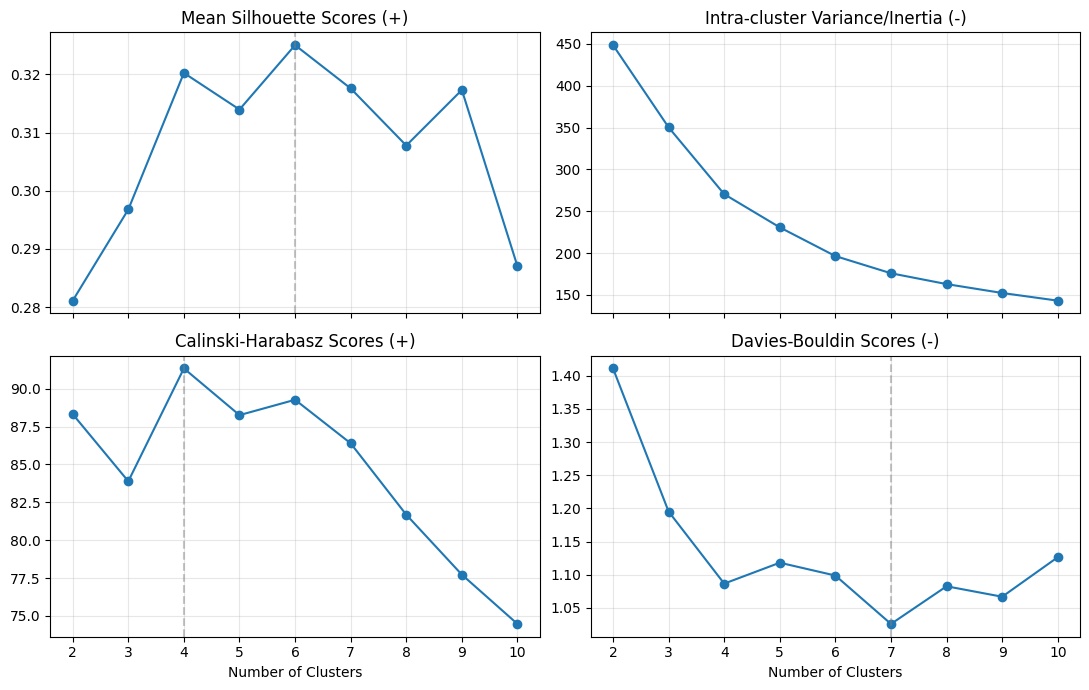

In [30]:
# Clustering k-means evaluación número clusters
importlib.reload(my)
my.kmeans_scree_plots(X_sc, n_max_clusters=10)

**Respuesta**: <br>
- K-means sugiere también 6 grupos, acorde al mejor modelo de clustering jerárquico!
- Silhouette score media más alta tiene lugar en 6 clusters, con un valor de approx 0.326. En promedio los registros están decentemente agrupadas en relación a los otros grupos.
- Tanto la inercia y la variabilidad explicada indican que a partir de 6 grupos en adelante, la ganancia en dichas métricas es pequeña y constante.

Ajusta el clustering K-means con el número de grupos seleccionado y genera una nueva variable en el conjunto de datos imputado llamada *'Cluster'* que recoja el número de grupo asignado a cada registro. El tipo de la variable debe ser entero (int).  

In [17]:
# Ajuste de k-means
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=6, n_init=30)
kmeans_model.fit(X_sc)
# Creación de variable cluster
clientes_imputed_iter['Cluster'] = kmeans_model.predict(X_sc)
clientes_imputed_iter

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1.0,19.0,15.000000,39.000000,3
1,1.0,21.0,15.000000,58.152762,3
2,0.0,20.0,16.000000,6.000000,0
3,0.0,23.0,16.000000,57.140722,3
4,0.0,31.0,60.584794,40.000000,1
...,...,...,...,...,...
195,0.0,35.0,120.000000,79.000000,5
196,0.0,45.0,126.000000,28.000000,4
197,1.0,32.0,126.000000,74.000000,5
198,1.0,32.0,137.000000,18.000000,4


Extrae los centroides de los grupos y comenta las principales características de cada grupo formado. 

In [18]:
# Centroides
pd.DataFrame(kmeans_model.cluster_centers_.round(2), columns=X_sc.columns,
             index=['Centroid_0','Centroid_1','Centroid_2','Centroid_3','Centroid_4','Centroid_5'])

,Age,Annual Income (k$),Spending Score (1-100),Gender
Centroid_0,0.63,-1.30,-1.37,0.47
Centroid_1,-0.70,-0.07,-0.09,0.40
Centroid_2,1.32,-0.17,-0.06,0.38
Centroid_3,-0.83,-1.30,0.76,0.38
Centroid_4,0.25,1.14,-1.35,0.48
Centroid_5,-0.45,1.04,1.31,0.42


In [19]:
clientes_imputed_iter.groupby('Cluster').mean().round(2)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,0.47,46.82,26.88,16.88
1,0.40,29.15,58.85,48.04
2,0.38,56.10,56.11,48.81
3,0.38,27.45,26.90,68.89
4,0.48,41.83,90.03,17.41
5,0.42,32.50,87.43,82.33


**Comentarios**: <br>
> - Peligro al ejecutar la creación de clusters de nuevo, ya que los números asignados cambian y afecta al orden de la interpretación de los clusters!
- **Cluster 4**: clientes de edad promedio con altos salarios pero baja propensión al gasto.
- **Cluster 1**: clientes jóvenes con salarios promedios y propensión promedio al gasto.
- **Cluster 2**: clientes mayores con salarios promedios y propensión promedio al gasto.
- **Cluster 3**: clientes jóvenes con salarios bajos pero alta propensión al gasto.
- **Cluster 5**: clientes jóvenes con altos salarios y alta propensión al gasto.
- **Cluster 0**: clientes de edad promedio con bajos salarios y baja propensión al gasto.

## Pregunta 14

De cara a la proyección de los grupos formados en el espacio de características y dado que estamos en R4. Nos planteamos reducir la dimensionalidad a 2 para poder interpretar con mayor claridad mediante un bonito biplot. 

Para llevar a cabo esta tarea, necesitaremos ajustar un PCA con 2 dimensiones a los datos de entrada al clustering que hemos generado, es decir, tal vez utilizamos el conjunto de datos escalado si lo consideramos necesario. Mostraremos las cargas de las variables en las componentes y haremos una pequeña interpretación inicial de las 2 componentes.


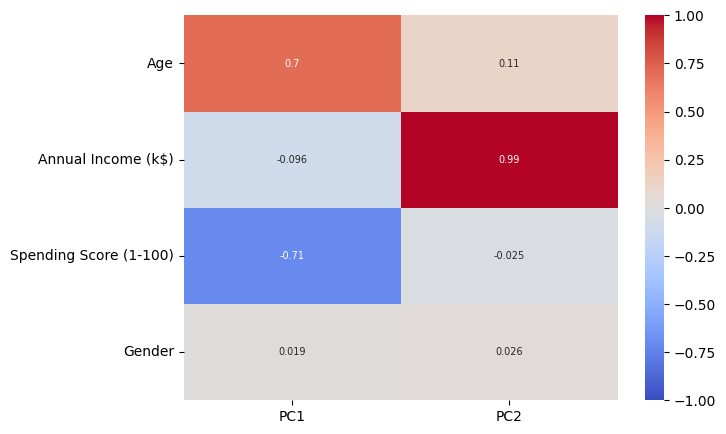

In [24]:
# Ajuste PCA 2 dimensiones
from sklearn.decomposition import PCA
pca = PCA()
pc_scores = pca.fit_transform(X_sc)

# Análisis de cargas
pc_loadings = my.get_PC_loadings(PCA_object=pca, feature_names_array=X_sc.columns).iloc[:,:2]

plt.figure(figsize=(7,5))
sns.heatmap(pc_loadings, annot=True, annot_kws={'fontsize': 7}, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

**Interpretación inicial**: <br>
- Empezamos por PC2: **PC2 captura casi toda la variabilidad de la variable de los salarios anuales**. Casi podríamos atribuirle el nombre de dicha variable al PC2!
- **PC1 captura sobre todo la variabilidad compartida entre las variables edad y puntuación del gasto**. Basándonos en las características de los 6 grupos sabemos que los más jóvenes son más propensos a gastar en comparación con los mayores, y de allí se intuye la alta colinearidad entre estas 2 variables. Por lo tanto, PC1 captura en gran medida la propensión al gasto.

Ahora generamos y mostramos el biplot para interpretar con mayor seguridad las componentes. 

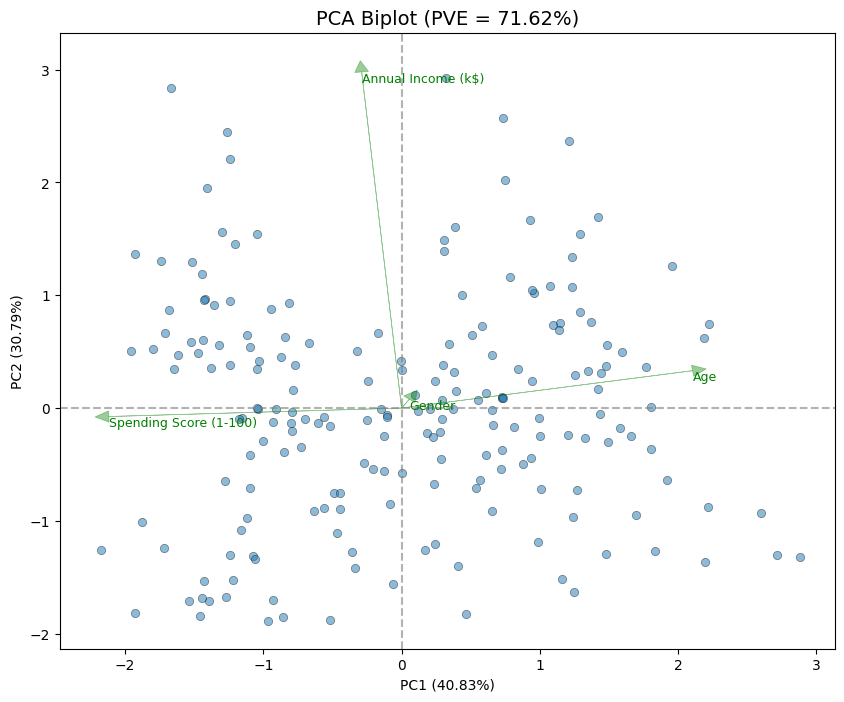

In [26]:
# Biplot
my.biplot_pca(PC_scores_array=pc_scores, PCA_object=pca, feature_names_array=X_sc.columns)

**Interpretación gráfica**: <br>
- Observamos que con 2 PCs se explica cerca del 72% de la variabilidad del conjunto de datos, lo cual no está nada mal.
- Se reafirma lo dicho anteriormente, `Age` y `Spending Score` componen principalmente el PC1 y el PC2 lo compone mayoritariamente `Annual Income`!
- Se observa la corta flecha de `Gender` pegada a las coordenadas de origen (0,0), lo cual indica su poca importancia en la construcción de ambos componentes principales.

Ahora que sabemos lo que represanta cada componente en el espacio original de las variables, necesitamos un conjunto de datos que contenga las columnas *PC1*,*PC2* y *Cluster* para realizar la representación de los clientes por grupos propuestos e interpretar las características de los grupos en el espacio de las componentes. 

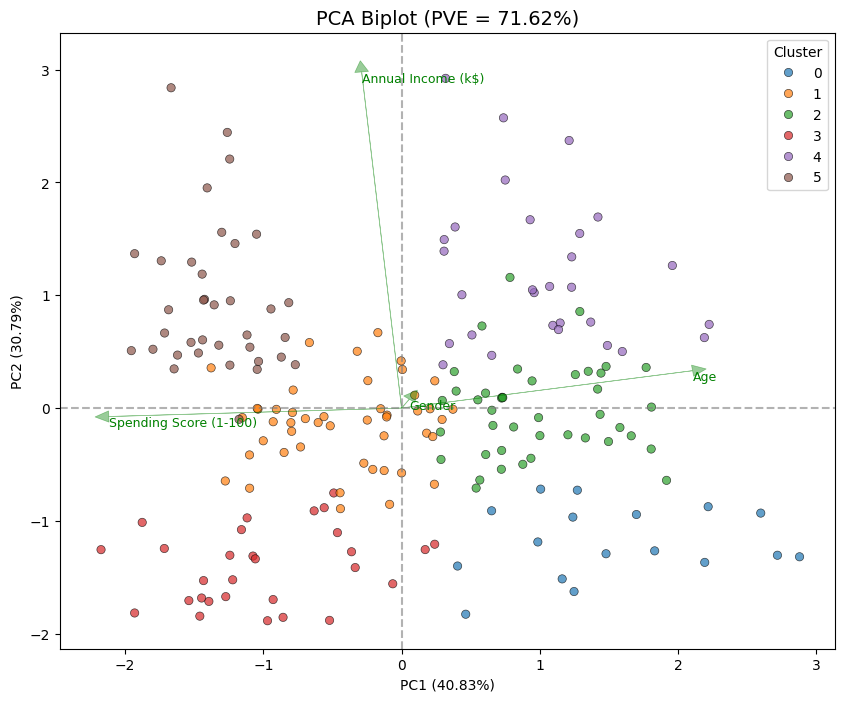

In [34]:
# Creación dataset dimensión reducida

# Representación de grupos en espacio de componentes
my.biplot_pca(PC_scores_array=pc_scores, PCA_object=pca, feature_names_array=X_sc.columns,
              hue=clientes_imputed_iter['Cluster'], palette='tab10', alpha_points=0.7)

**Interpretación de biplot**: <br>
- Acorde a las características promedios de los distintos clusters:
- El **cluster 0** está compuesto principalmente de clientes de edad promedio (tirando un poco hacia arriba) con bajos salarios y baja propensión al gasto. El hecho de que PC1 esté compuesto por variables originales con cargas opuestas hace que la interpretación no sea tan clara: en el caso del cluster 0, `Spending Score` (-1.37) está ponderando más en las puntuaciones que `Age` (0.63)!
- **Los clusters 1 y 2** contienen clientes con salarios y gastos promedios ($\approx 0$) con una clara diferencia en la edad: clientes jóvenes (-0.70) en el grupo 1 y clientes mayores (1.32) en el grupo 2. Por lo tanto, en este caso, la edad está ponderando más en los pc scores.
- En el cuadrante 3 (esquina inferior izq) se encuentra el **cluster 3**, con clientes jóvenes que ganan poco pero que gastan mucho.
- En el segundo cuadrante (esquina superior dch) están los que ganan mucho pero gastan poco (**cluster 4**).
- Y finalmente, en el primer cuadrante, está **el cluster 5**, comformado de aquellos (jóvenes) que ganan mucha pasta y gastan un huevo también (cansado de tanto escribir y pensar jeje ...)